# How To Export a Model Trained in Supervisely

After you have trained a model using Supervisely application, you can download its weights and config file, and use the model outside Supervisely Platform.

## 1. Download model weights and config from Team Files

**1. Go to Team Files:**

![Team Files](assets/Team_Files.png)

**2. Download model weights and config file:**

![Download model](assets/Download_model.png)

**Alternatively, you can download these files using Supervisely API:**

In [ ]:
# Install supervisely SDK if not installed
!pip install supervisely

In [ ]:
# Fill in these arguments:
server_address = "https://..."
api_token = "abcd0123456789..."
team_id = ...
path_to_weights_in_team_files = ...
path_to_config_in_team_files = ...
download_dir = "./my_model"

import supervisely as sly
api = sly.Api(server_address, api_token)
api.file.download(team_id, path_to_weights_in_team_files, f"{download_dir}/weights.pth")
api.file.download(team_id, path_to_config_in_team_files, f"{download_dir}/config.py")

## 2. Install requirements

**You can use our pre-builded docker image:**

`supervisely/mmdet:1.0.5`

Or build the image with this [Dockerfile](https://github.com/supervisely-ecosystem/mmdetection/blob/main/docker/Dockerfile).

**Alternatively, you can install only needed requirements manually with pip:**

In [ ]:
!pip install torch==1.10.0+cu111 torchvision==0.11.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html
!pip install mmcv-full==1.4.2 -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
!pip install mmdet==2.22.0 mmcls==0.23.1

## 3. Build the model

After you've installed requirements and downloaded model weights and config, **fill in the paths** where the files located:

In [1]:
# Put your paths here:
weights_path = "my_model/weights.pth"
config_path = "my_model/config.py"

device = "cuda:0"

In [15]:
# This is necessary imports for some models trained in Supervisely
# It will register custom modules to mmdet REGISTRY
# (make sure you run the notebook in the root directory of the repo)
from train.src import sly_mse_loss, sly_semantic_head

In [16]:
from mmcv import Config
from mmcv.cnn.utils import revert_sync_batchnorm
from mmdet.models import build_detector
from mmcv.runner import load_checkpoint

# build the model
cfg = Config.fromfile(config_path)
if 'pretrained' in cfg.model:
    cfg.model.pretrained = None
elif 'init_cfg' in cfg.model.backbone:
    cfg.model.backbone.init_cfg = None
cfg.model.train_cfg = None
model = build_detector(cfg.model, test_cfg=cfg.get('test_cfg'))
checkpoint = load_checkpoint(model, weights_path, map_location='cpu')
classes = cfg.checkpoint_config.meta.CLASSES
model.CLASSES = classes
model.cfg = cfg
model.to(device)
model.eval()
model = revert_sync_batchnorm(model)

load checkpoint from local path: my_model/weights.pth


## 4. Inference

In [17]:
from mmdet.apis.inference import inference_detector

image_path = "demo_data/image_02.jpg"
result = inference_detector(model, image_path)

/usr/local/lib/python3.8/dist-packages/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


## 5. Visualize

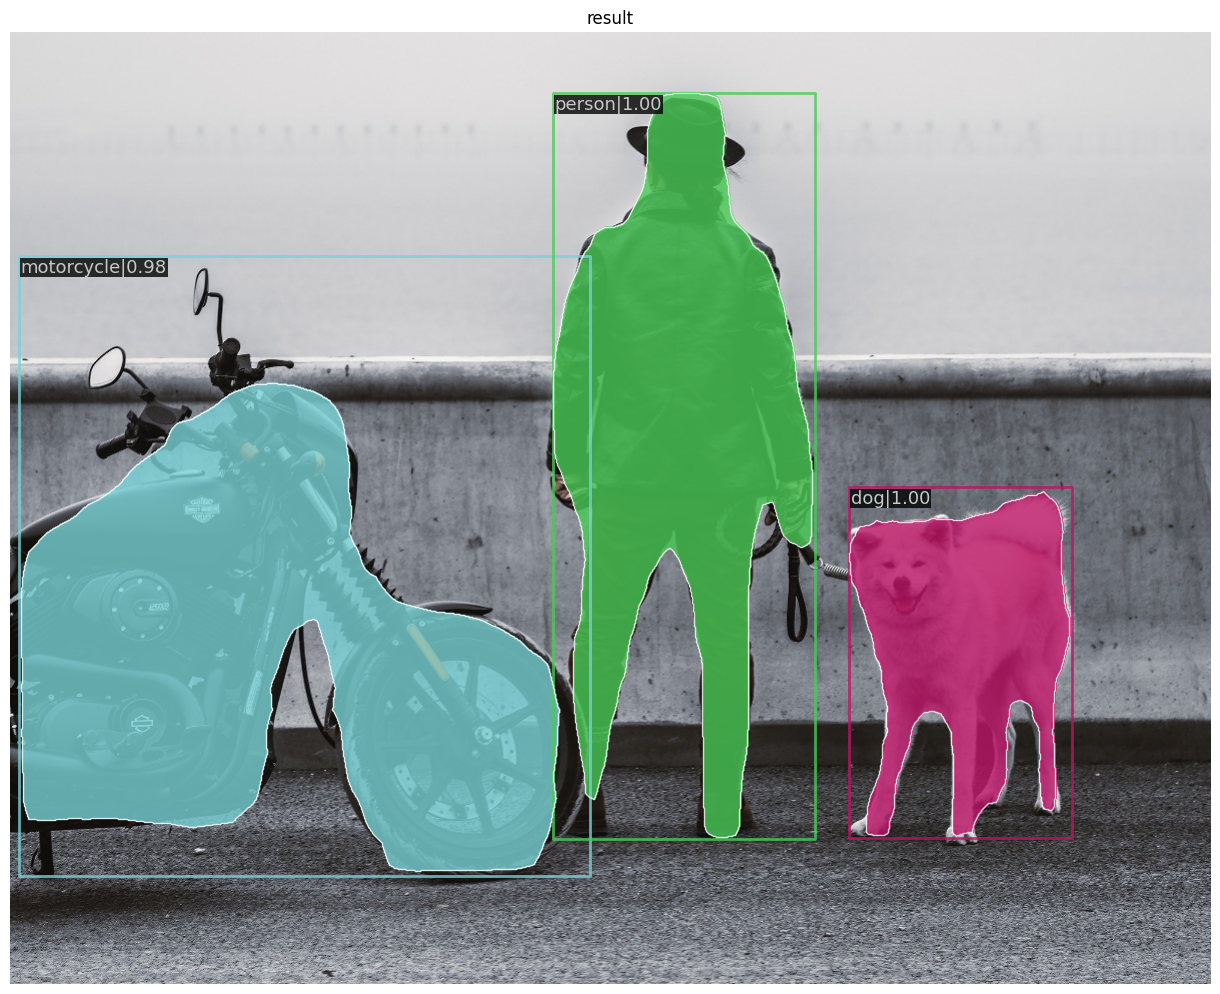

In [18]:
from mmdet.apis import show_result_pyplot

show_result_pyplot(model, image_path, result)